# What is this notebook about
This notebook will generate the segmentation masks for all the images 

> Please ensure you have downloaded the necessary data first from the <a href="https://spacenet.ai/sn6-challenge/">SpaceNet 6 Website</a>. Only download the training data!

# Setup and Imports

In [1]:
import os
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm 

import fiona
import rasterio
from rasterio.plot import show as show_raster, reshape_as_raster, reshape_as_image
from rasterio.mask import mask

# Global Variables

In [2]:
ROOT_DIR = Path('')
PATH_DATA_FULL = ROOT_DIR/'data_full/AOI_11_Rotterdam'

In [3]:
# An index, used just for inspecting one specific file
INSPECT_IDX = 0

# Helper Functions

### inspect_tif(tif_file)
Used to check out the basic features of a given tif file

In [4]:
def inspect_tif(tif_file):
    print("Count: {}".format(tif_file.count))

    # check the geospatial boundary of this image file, the corners of the image
    print("Corners: {}".format(tif_file.bounds))

    # getting dimensions, in map units of meters
    width = tif_file.bounds.right - tif_file.bounds.left
    height = tif_file.bounds.top - tif_file.bounds.bottom
    print("Width: {}, Height: {}".format(width, height))

    # getting pixel dimensions
    width_px = tif_file.width
    height_px = tif_file.height
    print("Pixels - Width: {}, Height: {}".format(width_px, height_px))

    # how many meters to a pixel
    width_ratio = width/width_px
    height_ratio = height/height_px
    print("m to px Ratio - Width: {}, Height: {}".format(width_ratio, height_ratio))

    # get coordinate reference system
    print("Coordinate Reference System: {}".format(tif_file.crs))

    # Get coordinates of top left and bottom right points since there is a coordinate reference system attached to this file
    topleft = tif_file.transform * (0,0)
    bottomright = tif_file.transform * (width, height)

    print("Top left coordinates: {}, Bottom right coordinates: {}".format(topleft, bottomright))

    # get basic metadata of this geotif file
    print("Metadata of geotiff file")
    print(tif_file.meta)     # can also use satdat.profile instead of satdat.meta

    # get number of bands by listing indices. count in the metadata refers to the number of bands
    print("Indexes: {}".format(tif_file.indexes))

### plot_bands(raster)
Plots out the individual bands of a raster file

In [5]:
def plot_bands(raster):
    channels = raster.read().shape[0]
    
    # PAN
    if channels == 1:
        show_raster(raster)
    
    # RGB
    elif channels == 3:
        fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
        show_raster((raster, 1), ax=axr, cmap='Reds', title='red channel')
        show_raster((raster, 2), ax=axg, cmap='Greens', title='green channel')
        show_raster((raster, 3), ax=axb, cmap='Blues', title='blue channel')
        plt.show()
    
    # Multispectral
    elif channels == 4:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(21,7))
        show_raster((raster, 1), ax=ax1, cmap='Reds', title='channel 1')
        show_raster((raster, 2), ax=ax2, cmap='Greens', title='channel 2')
        show_raster((raster, 3), ax=ax3, cmap='Blues', title='channel 3')
        show_raster((raster, 4), ax=ax4, cmap='Oranges', title='channel 4')
        plt.show()      
        
    else:
        print("Wrong format")

### plot_raster_mask()

In [16]:
def plot_raster_mask(raster, mask, index):    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))
    show_raster(raster, ax=ax1)
    show_raster(mask, ax=ax2)
    
    print("Index: {}".format(index))
    plt.show()        

# Masking

### Grab necessary files
We will use the geojson information, and PAN images to draw the mask. In the future, we will train on PS-RGB images. However since our mask will just be 2-dimensional, we only need PAN images (for simplicity)

In [7]:
PATH_GEOJSON = PATH_DATA_FULL/'geojson_buildings'
PATH_PAN = PATH_DATA_FULL/'PAN'

fnames_geojson_buildings = next(os.walk(PATH_GEOJSON))[2]
fnames_pan = next(os.walk(PATH_PAN))[2]

for fnames in [fnames_geojson_buildings, fnames_pan]:
    fnames.sort()

fnames_pan[:3]

['SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8679.tif',
 'SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8681.tif',
 'SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8683.tif']

['SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8679.tif',
 'SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8681.tif',
 'SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8683.tif']

### Create a directory for the masks

In [8]:
PATH_MASK = PATH_DATA_FULL/'mask'

if not os.path.exists(PATH_MASK):
    os.makedirs(PATH_MASK)

### Generate mask image file from geojson + tif
Using a mask to cut raster along boundary. We will consider every building collectively as 'buildings'

In [9]:
# x is a running index for simplicity - we have sorted the inputs
def generate_label(x):
    with fiona.open(PATH_GEOJSON/fnames_geojson_buildings[x]) as f:
        aoi = [feature['geometry'] for feature in f] 

    # crop=True crops the resulting raster to the AOI's bounding box
    with rasterio.open(PATH_PAN/fnames_pan[x]) as img:
        if aoi == []: 
            # there is no building in the image
            clipped = np.zeros((1,900,900), dtype=np.uint16)
            transform = img.transform
        else:
            clipped, transform = mask(img, aoi, crop=False)

        # edit the pixel values to max 65535 as a mask - uint16 max value
        clipped[clipped > 0] = 65535

        # use the metadata from the original image
        meta = img.meta.copy()

        # update metadata with new clipped boundary
        meta.update({"transform": transform,
                    "height": clipped.shape[1],
                    "width": clipped.shape[2]
                    })

        # write the clipped-and-cropped data to a new geotiff
        fname = fnames_geojson_buildings[x][:-8] + '.tif'

    with rasterio.open(PATH_MASK/fname, 'w', **meta) as dst:
        dst.write(clipped)

### Generate masks

In [10]:
for x, fname in tqdm(enumerate(fnames_geojson_buildings), total=len(fnames_geojson_buildings)):
    generate_label(x)
    
print("Masks generated")

100%|█████████████████████████████████████████████████████████████████████████| 3401/3401 [00:00<00:00, 1732640.34it/s]

Masks generated


100%|█████████████████████████████████████████████████████████████████████████| 3401/3401 [00:00<00:00, 1732640.34it/s]


Masks generated


### Inspect masks

In [13]:
fnames_mask = next(os.walk(PATH_MASK))[2]
fnames_mask.sort()

sample_mask = rasterio.open(PATH_MASK/fnames_mask[INSPECT_IDX])
inspect_tif(sample_mask)

Count: 1
Corners: BoundingBox(left=592318.6201042183, bottom=5749422.410443312, right=592768.6142138068, top=5749872.4045529)
Width: 449.9941095885588, Height: 449.9941095886752
Pixels - Width: 900, Height: 900
m to px Ratio - Width: 0.49999345509839865, Height: 0.499993455098528
Coordinate Reference System: EPSG:32631
Top left coordinates: (592318.6201042183, 5749872.4045529), Bottom right coordinates: (592543.6142138453, 5749647.410443273)
Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 900, 'height': 900, 'count': 1, 'crs': CRS.from_dict(init='epsg:32631'), 'transform': Affine(0.49999345509841014, 0.0, 592318.6201042183,
       0.0, -0.49999345509841014, 5749872.4045529)}
Indexes: (1,)
Count: 1
Corners: BoundingBox(left=592318.6201042183, bottom=5749422.410443312, right=592768.6142138068, top=5749872.4045529)
Width: 449.9941095885588, Height: 449.9941095886752
Pixels - Width: 900, Height: 900
m to px Ratio - Width: 0.49999345509839865, Height:

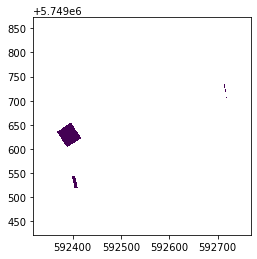

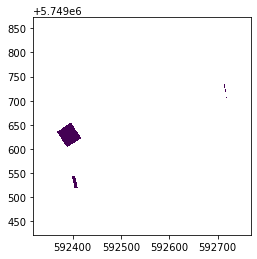

<AxesSubplot:>

<AxesSubplot:>

In [14]:
show_raster(sample_mask)

### Check mask accuracy

Index: 3158


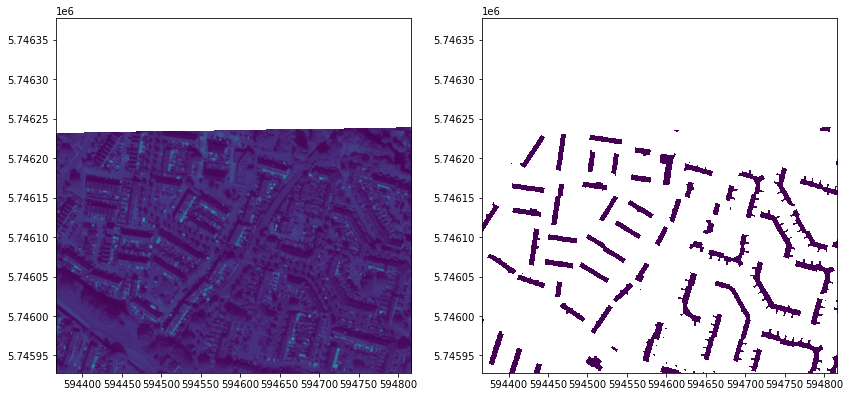

Index: 3255


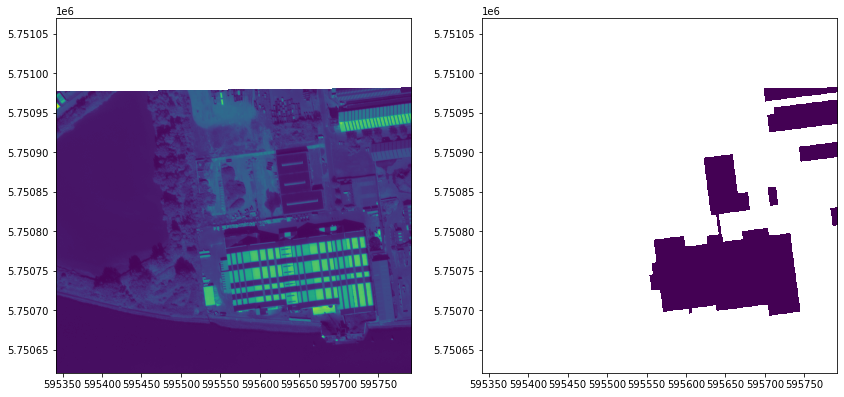

Index: 3055


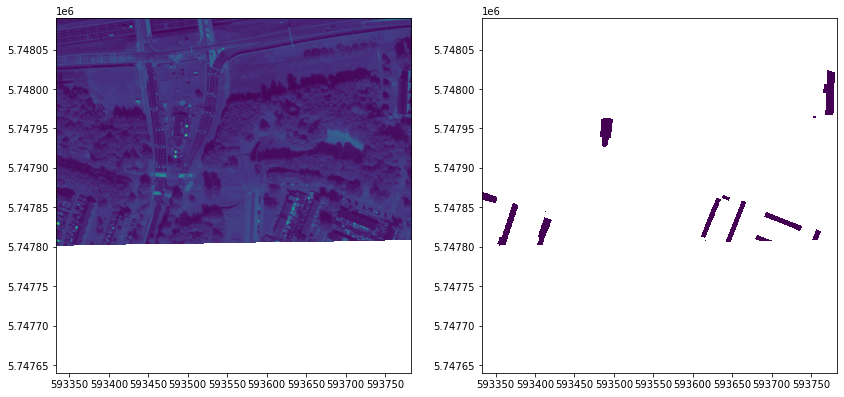

Index: 1636


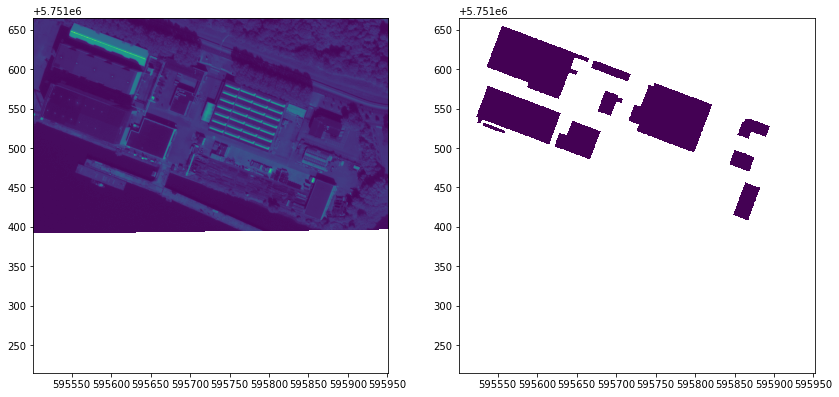

In [17]:
for i in range(4):
    index = np.random.randint(0, len(fnames_mask))
    raster = rasterio.open(PATH_PAN/fnames_pan[index])
    mask = rasterio.open(PATH_MASK/fnames_mask[index])
    
    plot_raster_mask(raster, mask, index)

# We've created the masks, now what?
Now that we have our masks generated, we can start splitting the 900x900 PS-RGB images and masks into more model-friendly sizes such as 224x224 256x256, 299x299 that are common to most CNNs